# Frame error in rare events
This notebook calculates frame error exclusively in pre-defined time epochs of rare events
\
Yarden, June 2021

In [2]:
# imports
from argparse import ArgumentParser
import configparser  # used to load 'min_segment_dur.ini'

from collections import defaultdict
import json
from pathlib import Path

import joblib
import numpy as np
import pandas as pd
import pyprojroot
import torch
from tqdm import tqdm

from vak import config, io, models, transforms
from vak.datasets.vocal_dataset import VocalDataset
import vak.device
import vak.files
from vak.labeled_timebins import lbl_tb2segments, majority_vote_transform, lbl_tb_segment_inds_list,     remove_short_segments
from vak.core.learncurve import train_dur_csv_paths as _train_dur_csv_paths
from vak.logging import log_or_print
from vak.labeled_timebins import (
    lbl_tb2segments,
    majority_vote_transform,
    lbl_tb_segment_inds_list,
    remove_short_segments
)
import copy
from collections import Counter
from crowsetta import Transcriber
from pathlib import Path

In [3]:
# Data folders and parameters
min_segment_dur_ini = 'D:\\Users\\yarde\\github\\tweetynet\\data\\configs\\min_segment_dur.ini  '
config = configparser.ConfigParser()
config.optionxform = lambda option: option  # monkeypatch optionxform so it doesn't lowercase animal IDs
config.read(Path(min_segment_dur_ini).expanduser().resolve())
min_segment_durs = {k: float(v) for k, v in config['min_segment_dur'].items()}

Root_learning_curve = Path('D:\\Users\\yarde\\vak_project\\BF\\learncurve')
Root_behavior = Path('D:\\Users\\yarde\\vak_project\\BF\\BFSongRepository')
Root_hidden_16 = Path('D:\\Users\\yarde\\vak_project\\BF\\hidden_size\\hidden_size_16')
Root_hidden_64 = Path('D:\\Users\\yarde\\vak_project\\BF\\hidden_size\\hidden_size_64')
birds = ['bl26lb16','gr41rd51','gy6or6','or60yw70']

# general parameters
min_p_ratio = 0.001
min_rare_count = 10
min_count = 50
max_p_ratio = 0.25

In [4]:
# functions to convert .not.mat annotations for a single .csv
def convert_notmats_to_csv(notmat_folder,csv_filename):
    scribe = Transcriber(format='notmat')
    annotpaths = [str(x) for x in Path(notmat_folder).glob('*.not.mat')]
    scribe.to_csv(annotpaths,csv_filename)

In [5]:
# creaate csv annotations for BFSongRepository
BF1_notmat_folder = 'D:\\Users\\yarde\\vak_project\\BF\\BFSongRepository\\bl26lb16\\041912'
BF1_csv_filename = 'D:\\Users\\yarde\\vak_project\\BF\\BFSongRepository\\bl26lb16\\bl26lb16_annotation.csv'
convert_notmats_to_csv(BF1_notmat_folder,BF1_csv_filename)
BF2_notmat_folder = 'D:\\Users\\yarde\\vak_project\\BF\\BFSongRepository\\gr41rd51\\06-21-12'
BF2_csv_filename = 'D:\\Users\\yarde\\vak_project\\BF\\BFSongRepository\\gr41rd51\\gr41rd51_annotation.csv'
convert_notmats_to_csv(BF2_notmat_folder,BF2_csv_filename)
BF3_notmat_folder = 'D:\\Users\\yarde\\vak_project\\BF\\BFSongRepository\\gy6or6\\032212'
BF3_csv_filename = 'D:\\Users\\yarde\\vak_project\\BF\\BFSongRepository\\gy6or6\\gy6or6_annotation.csv'
convert_notmats_to_csv(BF3_notmat_folder,BF3_csv_filename)
BF4_notmat_folder = 'D:\\Users\\yarde\\vak_project\\BF\\BFSongRepository\\or60yw70\\09-27-28-12'
BF4_csv_filename = 'D:\\Users\\yarde\\vak_project\\BF\\BFSongRepository\\or60yw70\\or60yw70_annotation.csv'
convert_notmats_to_csv(BF4_notmat_folder,BF4_csv_filename)

In [27]:
# Bird names and Root folders for experiments:
Root_learning_curve = Path('D:\\Users\\yarde\\vak_project\\BF\\learncurve')
Root_hidden_16 = Path('D:\\Users\\yarde\\vak_project\\BF\\hidden_size\\hidden_size_16')
Root_hidden_64 = Path('D:\\Users\\yarde\\vak_project\\BF\\hidden_size\\hidden_size_64')
birds = ['bl26lb16','gr41rd51','gy6or6','or60yw70']
annotations = {'bl26lb16':BF1_csv_filename,'gr41rd51':BF2_csv_filename,'gy6or6':BF3_csv_filename,'or60yw70':BF4_csv_filename}

In [22]:
# function to locate rare events
def locate_rare_events(path_annot_csv,labelmap,degree=3):
    if 'unlabeled' in labelmap.keys():
        unl_shift = 1
    else:
        unl_shift = 0
    inverse_labelmap = dict((v, k) for k, v in labelmap.items())
    annot_df = pd.read_csv(path_annot_csv)
    filenames = np.unique(annot_df.audio_path)
    labels = "".join([l for l in labelmap.keys() if l != 'unlabeled'])
    nsyls = len(labels)
    # create ngram matrix
    if degree==3:
        transmat = np.zeros((nsyls,nsyls,nsyls))
    else:
        transmat = np.zeros((nsyls,nsyls))
    for filename in filenames:
        label_idx_seq = np.array([labelmap[x]-unl_shift for x in annot_df[annot_df.audio_path==filename].label if x in labelmap.keys()])
    
        if degree==3:
            for i in range(len(label_idx_seq)-2):
                a=label_idx_seq[i]; b=label_idx_seq[i+1]; c=label_idx_seq[i+2]
                transmat[a,b,c] +=1
        else:
            for i in range(len(label_idx_seq)-1):
                a=label_idx_seq[i]; b=label_idx_seq[i+1];
                transmat[a,b] +=1
        
    # find forking transition points
    if degree==3:
        syl1 = []
        syl2 = []
        outsyls = []
        for a in range(unl_shift,nsyls):
            for b in range(unl_shift,nsyls):
                if sum(np.squeeze(transmat[a-unl_shift,b-unl_shift,:]) > 0) > 1:
                    syl1.append(inverse_labelmap[a])
                    syl2.append(inverse_labelmap[b])
                    outsyls.append(np.squeeze(transmat[a-unl_shift,b-unl_shift,:]))
        rare_events_df = pd.DataFrame({'a':syl1,'b':syl2,'trans_outcome':outsyls})
    else:
        syl1 = []
        outsyls = []
        for a in range(unl_shift,nsyls):
            if sum(np.squeeze(transmat[a-unl_shift,:]) > 0) > 1:
                syl1.append(inverse_labelmap[a]);
                outsyls.append(np.squeeze(transmat[a0unl_shift,:]))
        rare_events_df = pd.DataFrame({'a':syl1,'trans_outcome':outsyls})    
    return rare_events_df
    

In [8]:
# Curate 2nd and 3rd order rare events

In [9]:
def load_network_results(path_to_config=None,
                        spect_scaler_path = None,
                        csv_path=None,
                        labelmap_path=None,
                        checkpoint_path=None,
                        window_size = 370,
                        hidden_size = None,
                        min_segment_dur = 0.01,
                        num_workers = 12,
                        device='cuda',
                        spect_key='s',
                        timebins_key='t',
                        freq_key = 'f',
                        test_all_files=False):
    '''
    This function loads a model from an EVAL config file or from specified parameters, loads a model, and returns its outputs 
    for a specified test set.
    
    Setting 'test_all_files=True' will create a copy of the list in csv_path where all files are in the test set.
    '''
    if path_to_config:
        # ---- get all the parameters from the config we need
        cfg = config.parse.from_toml_path(path_to_config)
        if cfg.eval: 
            model_config_map = config.models.map_from_path(path_to_config, cfg.eval.models)
            csv_path = cfg.eval.csv_path
            labelmap_path = cfg.eval.labelmap_path
            checkpoint_path = cfg.eval.checkpoint_path
            window_size = cfg.dataloader.window_size
            num_workers = cfg.eval.num_workers
            if spect_scaler_path:
                spect_scaler_path = cfg.eval.spect_scaler_path
        else:
            print('config file must hold parameters in an [EVAL] section')
            return None
    else:
        if hidden_size:
            model_config_map = {'TweetyNet': {'loss': {}, 'metrics': {}, 'network': {'hidden_size':hidden_size}, 'optimizer': {'lr': 0.001}}}
        else:
            model_config_map = {'TweetyNet': {'loss': {}, 'metrics': {}, 'network': {}, 'optimizer': {'lr': 0.001}}}
        
    with labelmap_path.open('r') as f:
        labelmap = json.load(f)
    if spect_scaler_path:
        spect_standardizer = joblib.load(spect_scaler_path)
    else:
        spect_standardizer = None
    # prepare evaluation data
    csv_df = pd.read_csv(csv_path)
    if test_all_files==True: # allow creating a new csv 'csv_path_test.csv' where all entries are 'test'
        csv_df['split'] = 'test'
        csv_df.to_csv(csv_path.parent.joinpath(csv_path.stem + '_test.csv'))
        csv_path = csv_path.parent.joinpath(csv_path.stem + '_test.csv')
    csv_df = csv_df[csv_df.split == 'test']
    
    item_transform = transforms.get_defaults('eval',
                                                 spect_standardizer=spect_standardizer,
                                                 window_size=window_size,
                                                 return_padding_mask=True,
                                                 )

    eval_dataset = VocalDataset.from_csv(csv_path=csv_path,
                                         split='test',
                                         labelmap=labelmap,
                                         spect_key=spect_key,
                                         timebins_key=timebins_key,
                                         item_transform=item_transform,
                                         )

    eval_data = torch.utils.data.DataLoader(dataset=eval_dataset,
                                            shuffle=False,
                                            # batch size 1 because each spectrogram reshaped into a batch of windows
                                            batch_size=1,
                                            num_workers=num_workers)
    input_shape = eval_dataset.shape
    # if dataset returns spectrogram reshaped into windows,
    # throw out the window dimension; just want to tell network (channels, height, width) shape
    if len(input_shape) == 4:
        input_shape = input_shape[1:]

    models_map = models.from_model_config_map(
        model_config_map,
        num_classes=len(labelmap),
        input_shape=input_shape
    )
    model_name = 'TweetyNet'
    model = models_map['TweetyNet']
    model.load(checkpoint_path)
    #metrics = model.metrics  # metric name -> callable map we use below in loop
    if device is None:
        device = vak.device.get_default_device()
    pred_dict = model.predict(pred_data=eval_data,
                              device=device)
    
    
    annotation_dfs = [pd.DataFrame(eval_dataset.annots[file_number].seq.as_dict()) for file_number in range(len(csv_df))]
   
    return csv_df, annotation_dfs, pred_dict, labelmap

def seq_in_seq(long_seq,target_seq):
    #import pdb
    #pdb.set_trace()
    onsets = []
    offsets = []
    for onset in np.arange(0,len(long_seq)-len(target_seq)):
        if list(long_seq)[onset:onset+len(target_seq)] == list(target_seq):
            onsets.append(onset)
            offsets.append(onset+len(target_seq))
    return onsets,offsets

In [10]:
# Function to summarize experiments

In [18]:
def create_results(annot_path,rare_trans_df,labelmap,csv_df,pred_dict,degree=3):
    if 'unlabeled' in labelmap.keys():
        unl_shift = 1
    else:
        unl_shift = 0
    labels = "".join([l for l in labelmap.keys() if l != 'unlabeled'])
    df_annot = pd.read_csv(annot_path)
    inverse_labelmap = dict((v, k) for k, v in labelmap.items())
    nsyls = len(labels)
    sequences = []
    ratios = []
    totals = []
    for n in range(len(rare_trans_df)):
        stem = np.array(rare_trans_df.loc[n,['a','b']])
        trans_n = np.array(rare_trans_df.loc[n,'trans_outcome'])
        tot_num_event = sum(trans_n)
        trans_p = trans_n/tot_num_event
        max_p = max(trans_p)
        rec_trans_p = trans_p/max_p
        if tot_num_event >= min_count:
            for i in range(len(rec_trans_p)):
                if ((rec_trans_p[i] <= max_p_ratio) & (trans_n[i] > min_rare_count) & (trans_p[i] > min_p_ratio)):
                    print('Transition added: ',stem,'to',inverse_labelmap[i+unl_shift])
                    ratios.append(rec_trans_p[i])
                    sequences.append(np.append(stem,inverse_labelmap[i+unl_shift]))
                    totals.append(trans_n)

    names = [Path(x).name for x in csv_df['audio_path']]
    spect_names = [x for x in csv_df['spect_path']]

    idxs = []
    times_on=[]
    times_off=[]
    seq_idxs = []
    for ind,name in enumerate(names):
        temp_df = copy.deepcopy(df_annot[[Path(x).name == name for x in df_annot.audio_path]])
        for seq_id,seq in enumerate(sequences):
            onsets,offsets = seq_in_seq(np.array(temp_df.label),seq)
            if len(onsets)>0:
                idxs.append(ind)
                times_on.append([temp_df['onset_s'].iloc[x-1] for x in offsets])
                times_off.append([temp_df['offset_s'].iloc[x-1] for x in offsets])
                seq_idxs.append(seq_id)
                #print('seq:',seq,'in',name,':',times_on[-1])


    # now collect frame error rate

    argmax_labels = []
    argmax_labels_maj = []
    cnt=0
    for idx,seq_idx,t_ons,t_offs in zip(idxs,seq_idxs,times_on,times_off):
        #print(cnt)
        #spect = vak.files.spect.load(str(spect_names[idx]))['s']
        model_output = pred_dict[str(spect_names[idx])]
        model_output = np.squeeze(model_output.cpu().numpy())
        model_output = np.transpose(model_output,(0,2,1))
        m_shape = np.shape(model_output)
        model_output = model_output.reshape(m_shape[0]*m_shape[1],m_shape[2])
        t_vec = vak.files.spect.load(str(spect_names[idx]))['t']#[0] #remember to remove [0]
        f_vec = vak.files.spect.load(str(spect_names[idx]))['f']#[0]   
        model_output = model_output[:len(t_vec)]
        #import pdb
        #pdb.set_trace()
        #model_output_argmax = np.array([int(inverse_labelmap[(x)]) if x>0 else 0 for x in np.argmax(model_output,axis=1)])
        model_output_argmax = np.argmax(model_output,axis=1)
        tmp = [model_output_argmax[(t_vec >= t_on) & (t_vec <= t_off)] for t_on,t_off in zip(t_ons,t_offs)]
        argmax_labels.append(np.concatenate(tmp))
        tmp_maj = []
        for t in tmp:
            tmp_maj.append(list(Counter(t).most_common(1)[0])[0]*np.ones_like(t))
        argmax_labels_maj.append(np.concatenate(tmp_maj))
        
        
    errs_maj = []
    errs=[]
    ns = []
    for i_seq,seq in enumerate(sequences):
        ratio = ratios[i_seq]
        label = seq[-1]
        tmp_argmax_seq_labels = [[inverse_labelmap[y] for y in argmax_labels[x]] for x in np.where(np.array(seq_idxs) == i_seq)[0]]
        if len(tmp_argmax_seq_labels) > 0:
            argmax_seq_labels = np.concatenate(tmp_argmax_seq_labels)
            print('seq:',seq,'ratio:',ratio,'err',1-np.mean(argmax_seq_labels == label),'n',totals[i_seq])
            errs.append(1-np.mean(argmax_seq_labels == label))
        else:
            print('seq:',seq,'does not appear in the test set')
            errs.append(None)
        tmp_argmax_seq_labels = [[inverse_labelmap[y] for y in argmax_labels_maj[x]] for x in np.where(np.array(seq_idxs) == i_seq)[0]]
        if len(tmp_argmax_seq_labels) > 0:
            argmax_seq_labels = np.concatenate(tmp_argmax_seq_labels)
            errs_maj.append(1-np.mean(argmax_seq_labels == label))
            ns.append(len(argmax_seq_labels))
        else:
            #print('seq:',seq,'does not appear in the test set')
            errs_maj.append(None)
            ns.append(None)
    outdict={'sequences':sequences, 
             'ratios':ratios, 
             'totals':totals, 
             'idxs':idxs, 
             'times_on':times_on, 
             'times_off':times_off, 
             'seq_idxs':seq_idxs,  
             'argmax_labels':argmax_labels, 
             'argmax_labels_maj':argmax_labels_maj, 
             'errs_maj':errs_maj, 
             'errs':errs, 
             'ns':ns}    
    return outdict

In [79]:
# summarize results with hidden_size=16
window_size = 176
hidden_size = 16
training_dur_summary = []
ratio_summary = []
errs_summary = []
errs_maj_summary = []
errs_se_summary = []
errs_se_maj_summary = []

for bird in birds:
    min_segment_dur = min_segment_durs[bird]
    result_folder = [d for d in Root_hidden_16.joinpath(bird).iterdir()][0]
    train_dur_folders = [d for d in result_folder.iterdir() if d.is_dir()]
    for curr_train_folder in train_dur_folders:
        replicate_folders = [d for d in curr_train_folder.iterdir() if d.is_dir()]
        ods = []
        for curr_replicate_folder in replicate_folders:
            path_labelmap = curr_replicate_folder.joinpath('labelmap.json')
            if curr_replicate_folder.joinpath('StandardizeSpect').exists():
                spect_scaler_path = curr_replicate_folder.joinpath('StandardizeSpect')
            else:
                spect_scaler_path = None

            checkpoint_path = curr_replicate_folder.joinpath('TweetyNet','checkpoints','max-val-acc-checkpoint.pt')
            csv_path = [f for f in Root_learning_curve.joinpath(bird).glob('*.csv')][0]
            csv_df, annotation_dfs, pred_dict, labelmap = load_network_results(path_to_config=None,
                                                                             spect_scaler_path = spect_scaler_path,
                                                                             csv_path=csv_path,
                                                                             labelmap_path=path_labelmap,
                                                                             checkpoint_path=checkpoint_path,
                                                                             window_size = window_size,
                                                                             hidden_size = hidden_size,
                                                                             min_segment_dur = min_segment_dur,
                                                                             num_workers = 4,
                                                                             device='cuda',
                                                                             spect_key='s',
                                                                             timebins_key='t',
                                                                             freq_key = 'f',
                                                                             test_all_files=False)
            rare_trans_df = locate_rare_events(annotations[bird],labelmap,degree=3)
            od = create_results(annotations[bird],rare_trans_df,labelmap,csv_df,pred_dict,degree=3)
            ods.append(od)
            print('Done',curr_replicate_folder)
        #locate_rare_events(BF1_csv_filename,'output_folder',labelmap,degree=3)
        mn=np.nanmean(np.array([x['errs'] for x in ods]).astype(float),axis=0)
        sd=np.nanstd(np.array([x['errs'] for x in ods]).astype(float),axis=0)
        mn_maj=np.nanmean(np.array([x['errs_maj'] for x in ods]).astype(float),axis=0)
        sd_maj=np.nanstd(np.array([x['errs_maj'] for x in ods]).astype(float),axis=0)
        
        errs_summary.append(mn)
        errs_maj_summary.append(mn_maj)
        errs_se_summary.append(sd/np.sqrt(10))
        errs_se_maj_summary.append(sd_maj/np.sqrt(10))
        
        ratio_summary.append(ods[0]['ratios'])
        
        training_dur_summary.append(curr_train_folder.parts[-1].split('_')[-1])
#%%


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gr41rd51\results_210526_160858\train_dur_120s\replicate_1\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.08it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 0.33333333333333337 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.2990654205607477 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.03181818181818186 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.028846153846153855 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.016949152542372836 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.020325203252032575 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.28378378378378377 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.13it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 1.0 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.39252336448598135 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.06666666666666665 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.019230769230769273 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.05084745762711862 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.028455284552845517 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.09459459459459463 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
seq: ['i' 'i

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.15it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 0.9333333333333333 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.28037383177570097 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.09848484848484851 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.05769230769230771 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.0 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.03252032520325199 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.21283783783783783 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
seq: ['i' 'i' '

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.16it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 1.0 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.20560747663551404 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.034848484848484795 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.019230769230769273 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.016949152542372836 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.04471544715447151 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.402027027027027 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
seq: ['i' 'i'

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.15it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 0.9 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.2710280373831776 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.10757575757575755 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.028846153846153855 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.016949152542372836 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.04471544715447151 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.11486486486486491 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
seq: ['i' 'i'

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.15it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 0.7333333333333334 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.33644859813084116 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.034848484848484795 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.028846153846153855 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.016949152542372836 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.028455284552845517 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.29391891891891897 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.15it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 0.7 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.31775700934579443 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.040909090909090895 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.009615384615384581 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.016949152542372836 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.03658536585365857 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.17567567567567566 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
seq: ['i' '

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.15it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 1.0 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.3738317757009346 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.036363636363636376 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.009615384615384581 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.27118644067796616 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.04471544715447151 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.19256756756756754 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
seq: ['i' 'i'

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.14it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 1.0 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.30841121495327106 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.06212121212121213 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.028846153846153855 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.016949152542372836 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.04065040650406504 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.33108108108108103 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
seq: ['i' 'i

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.14it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 1.0 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.2710280373831776 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.05303030303030298 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.04807692307692313 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.016949152542372836 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.04065040650406504 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.10810810810810811 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
seq: ['i' 'i' 

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.14it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 0.9 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.3271028037383178 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.042424242424242475 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.028846153846153855 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.0 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.06504065040650409 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.21621621621621623 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
seq: ['i' 'i' 'j'] ratio: 0.0

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.13it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 0.4666666666666667 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.2429906542056075 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.033333333333333326 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.019230769230769273 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.0 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.028455284552845517 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.2364864864864865 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
seq: ['i' 'i' 

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.13it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 0.30000000000000004 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.3457943925233645 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.0757575757575758 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.04807692307692313 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.05084745762711862 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.04065040650406504 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.25 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
seq: ['i' 'i' '

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.14it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 1.0 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.23364485981308414 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.028787878787878807 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.028846153846153855 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.0 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.024390243902439046 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.25 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
seq: ['i' 'i' 'j'] ratio: 0.07743785850860

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.14it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 0.23333333333333328 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.05607476635514019 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.022727272727272707 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.019230769230769273 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.016949152542372836 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.024390243902439046 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.2567567567567568 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.14it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 0.7666666666666666 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.19626168224299068 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.07424242424242422 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.009615384615384581 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.0 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.060975609756097615 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.027027027027026973 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
seq: ['i' 'i

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.14it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 0.3666666666666667 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.3271028037383178 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.037878787878787845 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.04807692307692313 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.016949152542372836 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.05284552845528456 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.18243243243243246 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.13it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 1.0 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.23364485981308414 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.09848484848484851 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.028846153846153855 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.44067796610169496 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.028455284552845517 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.030405405405405372 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
seq: ['i' '

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.15it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 0.23333333333333328 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.30841121495327106 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.051515151515151514 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.028846153846153855 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.0 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.03658536585365857 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.14527027027027029 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
seq: ['i' 'i

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.14it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 1.0 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.09345794392523366 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.039393939393939426 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.04807692307692313 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.0 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.07317073170731703 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.17229729729729726 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
seq: ['i' 'i' 'j'] ratio: 0.0

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.14it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 1.0 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.36448598130841126 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.23030303030303034 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.05769230769230771 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.11864406779661019 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.15040650406504064 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.3986486486486487 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
seq: ['i' 'i' '

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.13it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 0.8666666666666667 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.3551401869158879 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.2681818181818182 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.04807692307692313 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.03389830508474578 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.0934959349593496 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.32432432432432434 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
se

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.15it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 0.9 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.2990654205607477 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.0636363636363636 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.07692307692307687 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.06779661016949157 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.03252032520325199 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.2432432432432432 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
seq: ['i' 'i' 'j'

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.15it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 1.0 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.5233644859813085 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.21363636363636362 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.028846153846153855 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.06779661016949157 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.15040650406504064 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.44594594594594594 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
seq: ['i' 'i' 

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.13it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j
seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 1.0 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.23364485981308414 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.08181818181818179 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.04807692307692313 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.05084745762711862 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.

  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gr41rd51\results_210526_160858\train_dur_30s\replicate_5\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.10it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j
seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 1.0 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.47663551401869164 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.07878787878787874 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.07692307692307687 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.016949152542372836 n [  0.   0.   0.   0.   0.   0.   0.  22. 157

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.14it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 1.0 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.485981308411215 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.040909090909090895 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.125 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.03389830508474578 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.05691056910569103 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.33108108108108103 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
seq: ['i' 'i' 'j'] ratio: 0.0

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.13it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 0.7666666666666666 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.2710280373831776 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.07121212121212117 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.05769230769230771 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.06779661016949157 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.05284552845528456 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.4797297297297297 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
s

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.14it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 1.0 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.2429906542056075 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.14393939393939392 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.038461538461538436 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.18644067796610164 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.1260162601626016 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.21621621621621623 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
seq: ['i' 'i' '

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.13it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 1.0 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.5046728971962617 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.06515151515151518 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.028846153846153855 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.3389830508474576 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.04471544715447151 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.2601351351351351 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
seq: ['i' 'i' 'j

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.14it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 0.8666666666666667 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.2149532710280374 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.034848484848484795 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.08653846153846156 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.0 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.028455284552845517 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.19594594594594594 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
seq: ['i' 'i' 

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.14it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 0.8666666666666667 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.28971962616822433 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.07272727272727275 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.07692307692307687 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.05084745762711862 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.10569105691056913 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.2432432432432432 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]


batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.13it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 1.0 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.44859813084112155 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.17878787878787883 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.038461538461538436 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.38983050847457623 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.06504065040650409 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.42905405405405406 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
seq: ['i' 'i'

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.12it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 0.33333333333333337 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.31775700934579443 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.05303030303030298 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.05769230769230771 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.03389830508474578 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.03658536585365857 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.42905405405405406 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.14it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 1.0 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.16822429906542058 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.0757575757575758 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.009615384615384581 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.18644067796610164 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.04878048780487809 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.31756756756756754 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
seq: ['i' 'i' 

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.13it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 1.0 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.5981308411214954 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.09090909090909094 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.019230769230769273 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.10169491525423724 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.13414634146341464 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.2668918918918919 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
seq: ['i' 'i' '

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.11it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 1.0 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.5233644859813085 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.07878787878787874 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.04807692307692313 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.0 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.0934959349593496 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.20608108108108103 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
seq: ['i' 'i' 'j'] ratio: 0.0774

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.13it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 0.5 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.44859813084112155 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.07272727272727275 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.13461538461538458 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.016949152542372836 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.1382113821138211 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.21959459459459463 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
seq: ['i' 'i' 

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.14it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 0.23333333333333328 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.2710280373831776 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.22878787878787876 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.09615384615384615 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.30508474576271183 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.15040650406504064 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.3614864864864865 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]


batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.14it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 1.0 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.42056074766355145 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.12121212121212122 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.028846153846153855 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.016949152542372836 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.20731707317073167 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.2432432432432432 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
seq: ['i' 'i'

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.13it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 0.16666666666666663 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.25233644859813087 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.06060606060606055 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.009615384615384581 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.0 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.020325203252032575 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.08783783783783783 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
seq: ['i' 'i

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.13it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 0.43333333333333335 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.25233644859813087 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.024242424242424288 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.019230769230769273 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.0 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.03252032520325199 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.04054054054054057 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
seq: ['i' 'i

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.13it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 0.6333333333333333 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.30841121495327106 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.033333333333333326 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.019230769230769273 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.016949152542372836 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.06910569105691056 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.1182432432432432 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+0

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.14it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 0.033333333333333326 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.30841121495327106 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.045454545454545414 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.009615384615384581 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.05084745762711862 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.04878048780487809 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.09121621621621623 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.13it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 1.0 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.30841121495327106 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.013636363636363669 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.028846153846153855 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.0 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.016260162601625994 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.125 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
seq: ['i' 'i' 'j'] ratio: 0.0774378585086

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.16it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j
seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 0.06666666666666665 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.22429906542056077 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.021212121212121238 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.028846153846153855 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.0 n [  0.   0.   0.   0.   0.   0.   0.  22. 15

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.14it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 0.1333333333333333 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.3551401869158879 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.039393939393939426 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.038461538461538436 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.0 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.028455284552845517 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.060810810810810856 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
seq: ['i' 'i

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.13it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 0.033333333333333326 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.4392523364485982 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.024242424242424288 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.019230769230769273 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.016949152542372836 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.05691056910569103 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.1351351351351351 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.16it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 0.033333333333333326 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.39252336448598135 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.025757575757575757 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.038461538461538436 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.016949152542372836 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.08130081300813008 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.06756756756756754 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.14it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 1.0 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.39252336448598135 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.07727272727272727 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.009615384615384581 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.05084745762711862 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.05284552845528456 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.1182432432432432 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
seq: ['i' 'i' 

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.16it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 0.7 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.31775700934579443 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.039393939393939426 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.009615384615384581 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.0 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.016260162601625994 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.10472972972972971 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
seq: ['i' 'i' 'j'] ratio: 0

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.15it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 0.6666666666666667 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.42056074766355145 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.033333333333333326 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.019230769230769273 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.0 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.05284552845528456 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.05067567567567566 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
seq: ['i' 'i'

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.13it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 1.0 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.31775700934579443 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.021212121212121238 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.009615384615384581 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.0 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.024390243902439046 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.020270270270270285 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
seq: ['i' 'i' 'j'] ratio: 

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.13it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j
seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 0.33333333333333337 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.20560747663551404 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.018181818181818188 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.038461538461538436 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.016949152542372836 n [  0.   0.   0.   0.   0. 

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.13it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 0.23333333333333328 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.15887850467289721 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.037878787878787845 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.009615384615384581 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.016949152542372836 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.11788617886178865 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.020270270270270285 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.14it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 0.6666666666666667 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.11214953271028039 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.028787878787878807 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.019230769230769273 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.016949152542372836 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.016260162601625994 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.10472972972972971 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.12it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 0.7333333333333334 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.3271028037383178 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.040909090909090895 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.038461538461538436 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.0 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.020325203252032575 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.2601351351351351 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
seq: ['i' 'i' 

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.12it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 1.0 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.2710280373831776 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.06515151515151518 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.038461538461538436 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.016949152542372836 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.060975609756097615 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.1182432432432432 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
seq: ['i' 'i'

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.14it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 0.9 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.4392523364485982 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.07121212121212117 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.019230769230769273 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.016949152542372836 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.03658536585365857 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.04054054054054057 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
seq: ['i' 'i'

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.13it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 1.0 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.1869158878504673 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.027272727272727226 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.028846153846153855 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.0 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.020325203252032575 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.10810810810810811 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
seq: ['i' 'i' 'j'] ratio: 0.

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.14it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 0.6 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.22429906542056077 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.06212121212121213 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.019230769230769273 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.05084745762711862 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.03658536585365857 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.19932432432432434 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
seq: ['i' 'i'

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.14it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 0.6 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.28037383177570097 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.05757575757575761 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.04807692307692313 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.016949152542372836 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.028455284552845517 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.09797297297297303 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
seq: ['i' 'i

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.14it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 0.0 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.3457943925233645 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.07424242424242422 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.019230769230769273 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.0 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.024390243902439046 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.31418918918918914 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
seq: ['i' 'i' 'j'] ratio: 0.0

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.14it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 0.9333333333333333 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.28971962616822433 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.10909090909090913 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.038461538461538436 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.2542372881355932 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.06910569105691056 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.10472972972972971 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.14it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 1.0 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.31775700934579443 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.039393939393939426 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.038461538461538436 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.0 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.04878048780487809 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.14189189189189189 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
seq: ['i' 'i' 'j'] ratio: 0.

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.15it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 0.9666666666666667 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.30841121495327106 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.06212121212121213 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.038461538461538436 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.05084745762711862 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.07723577235772361 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.22635135135135132 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.13it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 0.9333333333333333 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.3271028037383178 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.033333333333333326 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.028846153846153855 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.03389830508474578 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.04471544715447151 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.375 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
seq: ['i' 'i

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.14it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 0.30000000000000004 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.4112149532710281 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.09999999999999998 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.019230769230769273 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.0 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.04065040650406504 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.2364864864864865 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
seq: ['i' 'i' '

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.16it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j


  0%|                                                                                           | 0/29 [00:00<?, ?it/s]

seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 1.0 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.3271028037383178 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.045454545454545414 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.028846153846153855 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.016949152542372836 n [  0.   0.   0.   0.   0.   0.   0.  22. 157.   0.   0.]
seq: ['e' 'i' 'i'] ratio: 0.23560209424083767 err 0.03658536585365857 n [  0.   0.   0.   0.   0.   1.   0.  45. 191.   0.   1.]
seq: ['i' 'i' 'a'] ratio: 0.05162523900573613 err 0.2601351351351351 n [5.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.046e+03 8.100e+01 0.000e+00 1.410e+02]
seq: ['i' 'i'

batch 28 / 29: 100%|███████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.15it/s]


Transition added:  ['a' 'b'] to f
Transition added:  ['a' 'b'] to i
Transition added:  ['c' 'd'] to i
Transition added:  ['d' 'e'] to j
Transition added:  ['d' 'i'] to i
Transition added:  ['e' 'i'] to i
Transition added:  ['i' 'i'] to a
Transition added:  ['i' 'i'] to j
Transition added:  ['i' 'i'] to m
Transition added:  ['i' 'j'] to j
seq: ['a' 'b' 'f'] ratio: 0.016923076923076923 err 0.06666666666666665 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['a' 'b' 'i'] ratio: 0.04 err 0.33644859813084116 n [  0.   0. 650.   1.   0.  11.   0.  26.   7.   0.   7.]
seq: ['c' 'd' 'i'] ratio: 0.14817880794701987 err 0.12272727272727268 n [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.208e+03 0.000e+00 0.000e+00
 1.790e+02 4.000e+00 1.000e+00 3.000e+00]
seq: ['d' 'e' 'j'] ratio: 0.018518518518518517 err 0.038461538461538436 n [  6.   0.   0.   0.   0. 756.   0. 238.  14.   0.   1.]
seq: ['d' 'i' 'i'] ratio: 0.14012738853503184 err 0.03389830508474578 n [  0.   0.   0.   0.   0.   

  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_120s\replicate_1\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.61it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.03256302521008403 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.028653295128939882 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_120s\replicate_1
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_120s\replicate_10\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.63it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.054621848739495826 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.0322349570200573 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_120s\replicate_10
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_120s\replicate_2\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.64it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.06617647058823528 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.02936962750716332 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_120s\replicate_2
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_120s\replicate_3\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.62it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.04621848739495793 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.043696275071633206 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_120s\replicate_3
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_120s\replicate_4\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:14<00:00,  2.53it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.05147058823529416 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.027220630372492782 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_120s\replicate_4
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_120s\replicate_5\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.60it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.04621848739495793 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.035816618911174825 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_120s\replicate_5
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_120s\replicate_6\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.61it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.04201680672268904 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.025071633237822355 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_120s\replicate_6
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_120s\replicate_7\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.61it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.04936974789915971 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.022206303724928378 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_120s\replicate_7
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_120s\replicate_8\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.60it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.06302521008403361 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.03080229226361031 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_120s\replicate_8
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_120s\replicate_9\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.62it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.037815126050420145 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.03080229226361031 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_120s\replicate_9
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_180s\replicate_1\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.64it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a
seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.03991596638655459 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.035100286532951275 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_180s\replicate_1


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_180s\replicate_10\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.61it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.06617647058823528 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.033667621776504286 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_180s\replicate_10
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_180s\replicate_2\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.63it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.05147058823529416 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.03724928366762181 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_180s\replicate_2
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_180s\replicate_3\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.61it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.07352941176470584 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.05014326647564471 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_180s\replicate_3
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_180s\replicate_4\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.62it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.03256302521008403 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.025071633237822355 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_180s\replicate_4
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_180s\replicate_5\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.58it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.03361344537815125 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.027220630372492782 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_180s\replicate_5
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_180s\replicate_6\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.64it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.05147058823529416 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.03724928366762181 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_180s\replicate_6
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_180s\replicate_7\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.62it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.054621848739495826 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.0386819484240688 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_180s\replicate_7
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_180s\replicate_8\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.60it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.07352941176470584 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.045128939828080195 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_180s\replicate_8
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_180s\replicate_9\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.61it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.04306722689075626 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.028653295128939882 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_180s\replicate_9
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_30s\replicate_1\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.61it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.040966386554621814 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.06160458452722062 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_30s\replicate_1
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_30s\replicate_10\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.63it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.07773109243697474 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.08810888252148996 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_30s\replicate_10
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_30s\replicate_2\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.61it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.03991596638655459 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.04799426934097417 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_30s\replicate_2
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_30s\replicate_3\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.63it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.04831932773109249 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.11819484240687683 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_30s\replicate_3
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_30s\replicate_4\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.62it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.0535714285714286 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.045128939828080195 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_30s\replicate_4
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_30s\replicate_5\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.63it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.05882352941176472 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.04871060171919772 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_30s\replicate_5
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_30s\replicate_6\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.62it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.0535714285714286 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.04942693409742116 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_30s\replicate_6
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_30s\replicate_7\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.63it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.04621848739495793 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.05730659025787965 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_30s\replicate_7
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_30s\replicate_8\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.62it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.040966386554621814 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.10530085959885382 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_30s\replicate_8
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_30s\replicate_9\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.61it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.05672268907563027 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.0644699140401146 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_30s\replicate_9
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_45s\replicate_1\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.62it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.04201680672268904 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.08739255014326652 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_45s\replicate_1
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_45s\replicate_10\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.63it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.05567226890756305 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.027936962750716332 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_45s\replicate_10
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_45s\replicate_2\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.61it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.11344537815126055 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.0515759312320917 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_45s\replicate_2
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_45s\replicate_3\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.63it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.05672268907563027 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.034383954154727836 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_45s\replicate_3
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_45s\replicate_4\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.61it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.03676470588235292 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.045845272206303744 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_45s\replicate_4
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_45s\replicate_5\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.62it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.05882352941176472 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.07020057306590255 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_45s\replicate_5
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_45s\replicate_6\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.62it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.04621848739495793 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.03724928366762181 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_45s\replicate_6
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_45s\replicate_7\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.60it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.03361344537815125 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.07808022922636104 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_45s\replicate_7
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_45s\replicate_8\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.61it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.04621848739495793 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.06876790830945556 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_45s\replicate_8
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_45s\replicate_9\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.62it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.05567226890756305 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.028653295128939882 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_45s\replicate_9
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_480s\replicate_1\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.62it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.03886554621848737 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.035816618911174825 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_480s\replicate_1
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_480s\replicate_10\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.60it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.040966386554621814 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.022922636103151817 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_480s\replicate_10
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_480s\replicate_2\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.62it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.03991596638655459 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.011461318051575908 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_480s\replicate_2
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_480s\replicate_3\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.62it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.050420168067226934 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.022206303724928378 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_480s\replicate_3
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_480s\replicate_4\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.63it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.027310924369747913 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.03080229226361031 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_480s\replicate_4
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_480s\replicate_5\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.61it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.04831932773109249 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.03080229226361031 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_480s\replicate_5
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_480s\replicate_6\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.63it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.0535714285714286 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.025071633237822355 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_480s\replicate_6
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_480s\replicate_7\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.62it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.04936974789915971 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.01862464183381085 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_480s\replicate_7
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_480s\replicate_8\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.63it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.034663865546218475 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.017908309455587412 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_480s\replicate_8
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_480s\replicate_9\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.63it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a
seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.028361344537815136 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.015759312320916874 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_480s\replicate_9


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_75s\replicate_1\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.62it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.04201680672268904 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.04154727793696278 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_75s\replicate_1
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_75s\replicate_10\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.63it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.05147058823529416 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.0322349570200573 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_75s\replicate_10
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_75s\replicate_2\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.62it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.05987394957983194 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.034383954154727836 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_75s\replicate_2
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_75s\replicate_3\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.62it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.03676470588235292 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.04871060171919772 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_75s\replicate_3
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_75s\replicate_4\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.63it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.04621848739495793 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.033667621776504286 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_75s\replicate_4
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_75s\replicate_5\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.60it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.0714285714285714 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.054441260744985676 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_75s\replicate_5
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_75s\replicate_6\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.61it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.047268907563025264 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.03939828080229224 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_75s\replicate_6
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_75s\replicate_7\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.59it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.07247899159663862 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.0644699140401146 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_75s\replicate_7
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_75s\replicate_8\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.60it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a


  0%|                                                                                           | 0/36 [00:00<?, ?it/s]

seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.050420168067226934 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.03008595988538687 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_75s\replicate_8
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_75s\replicate_9\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 35 / 36: 100%|███████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.63it/s]


Transition added:  ['e' 'f'] to i
Transition added:  ['i' 'i'] to a
seq: ['e' 'f' 'i'] ratio: 0.1089866156787763 err 0.04621848739495793 n [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.046e+03
 0.000e+00 1.140e+02 0.000e+00 0.000e+00]
seq: ['i' 'i' 'a'] ratio: 0.21882581271227558 err 0.06017191977077363 n [ 451.    0.    0.    0.    0.    0.    0.    0. 2061.    0.    0.]
Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\gy6or6\results_210526_233349\train_dur_75s\replicate_9


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_120s\replicate_1\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_120s\replicate_1
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_120s\replicate_10\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_120s\replicate_10
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_120s\replicate_2\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_120s\replicate_2
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_120s\replicate_3\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 31 / 32: 100%|███████████████████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.32it/s]


Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_120s\replicate_3
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_120s\replicate_4\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_120s\replicate_4
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_120s\replicate_5\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_120s\replicate_5
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_120s\replicate_6\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_120s\replicate_6
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_120s\replicate_7\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_120s\replicate_7
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_120s\replicate_8\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 31 / 32: 100%|███████████████████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.32it/s]


Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_120s\replicate_8
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_120s\replicate_9\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_120s\replicate_9
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_180s\replicate_1\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_180s\replicate_1
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_180s\replicate_10\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_180s\replicate_10
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_180s\replicate_2\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 31 / 32: 100%|███████████████████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.33it/s]


Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_180s\replicate_2
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_180s\replicate_3\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_180s\replicate_3
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_180s\replicate_4\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_180s\replicate_4
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_180s\replicate_5\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_180s\replicate_5
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_180s\replicate_6\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 31 / 32: 100%|███████████████████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.32it/s]


Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_180s\replicate_6
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_180s\replicate_7\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_180s\replicate_7
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_180s\replicate_8\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_180s\replicate_8
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_180s\replicate_9\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 31 / 32: 100%|███████████████████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.33it/s]


Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_180s\replicate_9


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_30s\replicate_1\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_30s\replicate_1
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_30s\replicate_10\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_30s\replicate_10
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_30s\replicate_2\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_30s\replicate_2
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_30s\replicate_3\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 31 / 32: 100%|███████████████████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.33it/s]


Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_30s\replicate_3
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_30s\replicate_4\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_30s\replicate_4
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_30s\replicate_5\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_30s\replicate_5
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_30s\replicate_6\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 31 / 32: 100%|███████████████████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.34it/s]


Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_30s\replicate_6
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_30s\replicate_7\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_30s\replicate_7
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_30s\replicate_8\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_30s\replicate_8
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_30s\replicate_9\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_30s\replicate_9
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_45s\replicate_1\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_45s\replicate_1
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_45s\replicate_10\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_45s\replicate_10
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_45s\replicate_2\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 31 / 32: 100%|███████████████████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.31it/s]


Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_45s\replicate_2
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_45s\replicate_3\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 31 / 32: 100%|███████████████████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.33it/s]


Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_45s\replicate_3
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_45s\replicate_4\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_45s\replicate_4
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_45s\replicate_5\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 31 / 32: 100%|███████████████████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.33it/s]


Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_45s\replicate_5
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_45s\replicate_6\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 31 / 32: 100%|███████████████████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.33it/s]


Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_45s\replicate_6
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_45s\replicate_7\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_45s\replicate_7
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_45s\replicate_8\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_45s\replicate_8
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_45s\replicate_9\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_45s\replicate_9
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_480s\replicate_1\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_480s\replicate_1
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_480s\replicate_10\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_480s\replicate_10
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_480s\replicate_2\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_480s\replicate_2
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_480s\replicate_3\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 31 / 32: 100%|███████████████████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.32it/s]


Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_480s\replicate_3
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_480s\replicate_4\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 31 / 32: 100%|███████████████████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.30it/s]


Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_480s\replicate_4


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_480s\replicate_5\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_480s\replicate_5
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_480s\replicate_6\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_480s\replicate_6
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_480s\replicate_7\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_480s\replicate_7
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_480s\replicate_8\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 31 / 32: 100%|███████████████████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.32it/s]


Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_480s\replicate_8
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_480s\replicate_9\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_480s\replicate_9
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_600s\replicate_1\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_600s\replicate_1
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_600s\replicate_10\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_600s\replicate_10
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_600s\replicate_2\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_600s\replicate_2
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_600s\replicate_3\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_600s\replicate_3
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_600s\replicate_4\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 31 / 32: 100%|███████████████████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.31it/s]


Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_600s\replicate_4
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_600s\replicate_5\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_600s\replicate_5
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_600s\replicate_6\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_600s\replicate_6
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_600s\replicate_7\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_600s\replicate_7
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_600s\replicate_8\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_600s\replicate_8
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_600s\replicate_9\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_600s\replicate_9
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_75s\replicate_1\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_75s\replicate_1
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_75s\replicate_10\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_75s\replicate_10
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_75s\replicate_2\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_75s\replicate_2
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_75s\replicate_3\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_75s\replicate_3
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_75s\replicate_4\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_75s\replicate_4
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_75s\replicate_5\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_75s\replicate_5
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_75s\replicate_6\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_75s\replicate_6
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_75s\replicate_7\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 31 / 32: 100%|███████████████████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.35it/s]


Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_75s\replicate_7
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_75s\replicate_8\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_75s\replicate_8
Loading checkpoint from:
D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_75s\replicate_9\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 31 / 32: 100%|███████████████████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.33it/s]


Done D:\Users\yarde\vak_project\BF\hidden_size\hidden_size_16\or60yw70\results_210527_045230\train_dur_75s\replicate_9


In [127]:
#(training_dur_summary[:7])
#(ratio_summary[:7])
#errs_summary 
#errs_maj_summary 
#errs_se_summary 
#errs_se_maj_summary 
data = dict((x,np.concatenate(np.array(errs_summary,dtype=object)[np.where(np.array(training_dur_summary) == x)])) for x in np.unique(training_dur_summary))
data_maj = dict((x,np.concatenate(np.array(errs_maj_summary,dtype=object)[np.where(np.array(training_dur_summary) == x)])) for x in np.unique(training_dur_summary))
all_ratios = dict((x,np.concatenate(np.array(ratio_summary,dtype=object)[np.where(np.array(training_dur_summary) == x)])) for x in np.unique(training_dur_summary))
durs = np.array([int(s[:-1]) for s in data.keys()])
durkeys = np.array([s for s in data.keys()])

In [146]:
p

0.23315772902572485

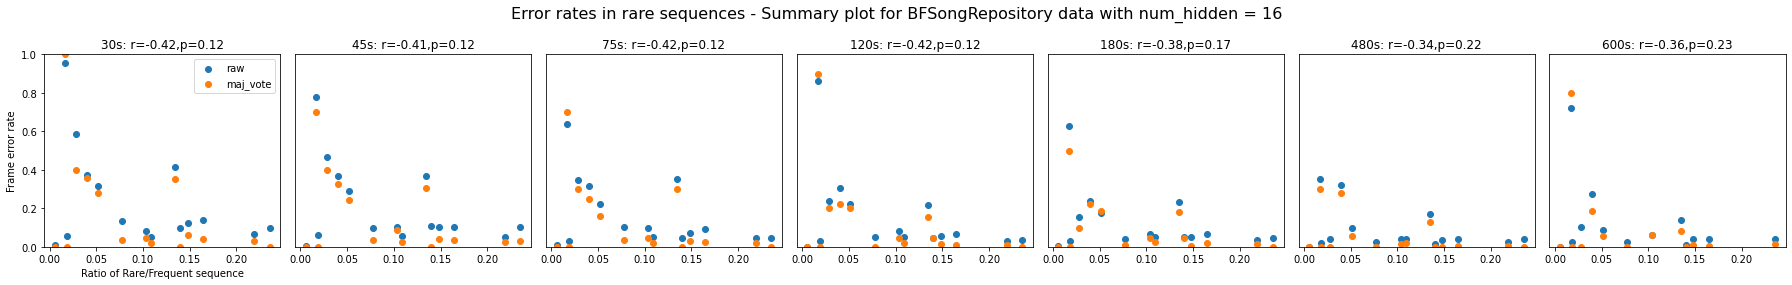

In [161]:
sortind = np.argsort(durs)
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
plt.figure(figsize=(25,4))
for i,e in enumerate(durkeys[sortind]):
    ax = plt.subplot(1,len(durs),i+1)
    ax.scatter(all_ratios[e],data[e])
    ax.scatter(all_ratios[e],data_maj[e])
    x = [all_ratios[e][pos] for pos,d in enumerate(data[e]) if not np.isnan(d)]
    y = [data[e][pos] for pos,d in enumerate(data[e]) if not np.isnan(d)]
    r,p = pearsonr(x,y)
    ax.set_title(e + ': r={0:1.2f},p={1:1.2f}'.format(r,p))
    ax.set_ylim([0,1])
    if i>0: 
        ax.set_yticks([])
    else:
        ax.set_ylabel('Frame error rate')
        ax.set_xlabel('Ratio of Rare/Frequent sequence')
        ax.legend(['raw','maj_vote'])
plt.suptitle('Error rates in rare sequences - Summary plot for BFSongRepository data with num_hidden = 16',fontsize=16)  
plt.tight_layout()
plt.show()

## Conclusion - for hidden_num=16:
#### 1. We examine the frame error in syllables 'X' in the sequences 'a-b-X' and look for relation to the rareity of 'a-b-X' compared to the most frequent alternative 'a-b-Y'
#### 2. High error rates in rare sequences are more likely to occur in very rare events but there is no significant correlation (pearsons r,p - high r values resulting from a few outliers).
#### 3. The trend depends on how well the model is trained (the duration of the training set)
#### 4. Using the majority vote cleanup almost always reduce the error rates.



In [ ]:
# summarize results with hidden_size=64
window_size = 176
hidden_size = 64
training_dur_summary = []
ratio_summary = []
errs_summary = []
errs_maj_summary = []
errs_se_summary = []
errs_se_maj_summary = []

for bird in birds:
    min_segment_dur = min_segment_durs[bird]
    result_folder = [d for d in Root_hidden_64.joinpath(bird).iterdir()][0]
    train_dur_folders = [d for d in result_folder.iterdir() if d.is_dir()]
    for curr_train_folder in train_dur_folders:
        replicate_folders = [d for d in curr_train_folder.iterdir() if d.is_dir()]
        ods = []
        for curr_replicate_folder in replicate_folders:
            path_labelmap = curr_replicate_folder.joinpath('labelmap.json')
            if curr_replicate_folder.joinpath('StandardizeSpect').exists():
                spect_scaler_path = curr_replicate_folder.joinpath('StandardizeSpect')
            else:
                spect_scaler_path = None

            checkpoint_path = curr_replicate_folder.joinpath('TweetyNet','checkpoints','max-val-acc-checkpoint.pt')
            csv_path = [f for f in Root_learning_curve.joinpath(bird).glob('*.csv')][0]
            csv_df, annotation_dfs, pred_dict, labelmap = load_network_results(path_to_config=None,
                                                                             spect_scaler_path = spect_scaler_path,
                                                                             csv_path=csv_path,
                                                                             labelmap_path=path_labelmap,
                                                                             checkpoint_path=checkpoint_path,
                                                                             window_size = window_size,
                                                                             hidden_size = hidden_size,
                                                                             min_segment_dur = min_segment_dur,
                                                                             num_workers = 4,
                                                                             device='cuda',
                                                                             spect_key='s',
                                                                             timebins_key='t',
                                                                             freq_key = 'f',
                                                                             test_all_files=False)
            rare_trans_df = locate_rare_events(annotations[bird],labelmap,degree=3)
            od = create_results(annotations[bird],rare_trans_df,labelmap,csv_df,pred_dict,degree=3)
            ods.append(od)
            print('Done',curr_replicate_folder)
        #locate_rare_events(BF1_csv_filename,'output_folder',labelmap,degree=3)
        mn=np.nanmean(np.array([x['errs'] for x in ods]).astype(float),axis=0)
        sd=np.nanstd(np.array([x['errs'] for x in ods]).astype(float),axis=0)
        mn_maj=np.nanmean(np.array([x['errs_maj'] for x in ods]).astype(float),axis=0)
        sd_maj=np.nanstd(np.array([x['errs_maj'] for x in ods]).astype(float),axis=0)
        
        errs_summary.append(mn)
        errs_maj_summary.append(mn_maj)
        errs_se_summary.append(sd/np.sqrt(10))
        errs_se_maj_summary.append(sd_maj/np.sqrt(10))
        
        ratio_summary.append(ods[0]['ratios'])
        
        training_dur_summary.append(curr_train_folder.parts[-1].split('_')[-1])